In [22]:
!date
import numpy as np, pandas as pd, pymc as pm, matplotlib.pyplot as plt, dismod_mr
%matplotlib inline

Tue Oct  3 21:57:01 PDT 2017


# Update of Anxiety in Conflict

Estimates for Fiona Charlson to present to WHO on October 6, 2017.

The data dictionary and covariates to be included are in separate tabs with the file but I have also listed them below. Hopefully there are not too many spurious errors that DisMod doesn’t like, but if there are just let me know and I’ll make fixes.

Thanks so much Abie. I’ll be taking these final estimates to Geneva with me on 6 October. Very curious to see how they may have changed!

## Anxiety

* •	Warrelated_events_ratio
* •	Symptom scale_coded
* •	Time_since_conflict
* •	Super_region

### Based on Anxiety Model from [2017](2017_05_17a_anxiety_in_conflict_replication_and_update.ipynb)
(an initial attempt to update this for Fiona for WHO)

In [23]:
# set random seed for reproducibility
np.random.seed(12345)

In [24]:
mdd = dismod_mr.data.load('/home/j/Project/dismod/output/dm-40553')

In [25]:
df = pd.io.excel.read_excel('data/Anxiety_Dataset_230917.xlsx', 'Anxiety data cleaned')

def float_or_nan(x):
    try:
        return float(x)
    except ValueError:
        return np.nan
    
assert float_or_nan(1) == 1
assert np.isnan(float_or_nan('-'))

In [26]:
assert np.all(~df.Age_start.isnull())
assert np.all(~df.Age_end.isnull())

# # fill in missing age start and age end
# assert np.isnan(df.loc[10, 'Age_start'])
# df.loc[10, 'Age_start'] = 0

# assert np.isnan(df.loc[10, 'Age_end'])
# df.loc[10, 'Age_end'] = 100

In [27]:
dm = dismod_mr.data.ModelData()

inp = pd.DataFrame(columns=dm.input_data.columns, index=df.index)

# data type, value, and uncertainty
inp.data_type = 'p'
inp.value = df.Parameter_value / df.Units
inp.effective_sample_size = df.Denominator

# geographic information (to be used for random effects)
inp.area = df.Country
#inp.area = df.Super_region.astype(str)

inp.sex = df.Sex.map({'Male':'male', 'Female':'female', 'Total':'total'})
inp.age_start = df.Age_start
inp.age_end = df.Age_end

inp.standard_error = np.nan
inp.upper_ci = np.nan
inp.lower_ci = np.nan

# setup model
dm.parameters['p'] = mdd.parameters['p'].copy()
dm.set_decreasing('p', 85, 101)
for i, row in df.iterrows():  # FIXME: cast-to-string currently need, unicode strings fail
    dm.hierarchy.add_edge('all', str(row['Country']))
    #dm.hierarchy.add_edge('all', str(row['Super_region']))
    #dm.hierarchy.add_edge(str(row['Super_region']), str(row['GBD_region']))
    #dm.hierarchy.add_edge(str(row['GBD_region']), str(row['Country']))

In [28]:
def float_or_nan(x):
    try:
        return float(x)
    except ValueError:
        return np.nan
    
assert float_or_nan(1) == 1
assert np.isnan(float_or_nan('-'))

In [29]:
# time since conflict categorical vars
for i in [3,1]:
    col = 'x_tsc_%d'%i
    inp[col] = df.Time_since_conflict_years==i

inp['x_length_of_conflict_geq_25'] = df.Length_of_conflict.map(float_or_nan) >= 25
inp['x_administration_method'] = df.Method_administration == 'Lay-interviewer'
inp['x_symptom_scale'] = df['Symptom scale_coded']  # all zero?


# TODO: Want to look at symptom scale, method of administration, time since conflict, length of conflict

In [30]:
inp.head()

,data_type,value,area,sex,age_start,age_end,year_start,year_end,standard_error,effective_sample_size,lower_ci,upper_ci,age_weights,x_tsc_3,x_tsc_1,x_length_of_conflict_geq_25,x_administration_method,x_symptom_scale
0,p,0.014706,Pakistan,male,18,80,NaN,NaN,NaN,408.000000,NaN,NaN,NaN,False,False,False,True,0
1,p,0.034000,Lebanon,male,60,99,NaN,NaN,NaN,287.000000,NaN,NaN,NaN,True,False,True,True,0
2,p,0.031000,Israel,male,14,17,NaN,NaN,NaN,497.000000,NaN,NaN,NaN,False,False,True,False,0
3,p,0.021000,Northern Ireland,male,18,64,NaN,NaN,NaN,523.809524,NaN,NaN,NaN,False,False,False,False,0
4,p,0.024000,Northern Ireland,male,18,64,NaN,NaN,NaN,458.333333,NaN,NaN,NaN,False,False,False,False,0


In [31]:
# add additional data rows to obtain output estimates for requested age groups
ages = [[0,10],
        [10,20],
        [20,30],
        [30,40],
        [40,50],
        [50,60],
        [60,70],
        [70,80]]
for age_start, age_end in ages:
    inp = inp.append(pd.Series({'data_type':'p',
                                'value': 0,
                                'effective_sample_size':0,
                                'area': 'all',
                                'sex': 'total',
                                'age_start': age_start,
                                'age_end': age_end,
                                'x_tsc_3': False,
                                'x_tsc_1': False,
                                'x_length_of_conflict_geq_25': False,
                                'x_administration_method': False,
                                'x_symptom_scale': 0                                
                                }), ignore_index=True)

In [32]:
inp.tail()

,data_type,value,area,sex,age_start,age_end,year_start,year_end,standard_error,effective_sample_size,lower_ci,upper_ci,age_weights,x_tsc_3,x_tsc_1,x_length_of_conflict_geq_25,x_administration_method,x_symptom_scale
83,p,0.0,all,total,30,40,NaN,NaN,NaN,0.0,NaN,NaN,NaN,False,False,False,False,0
84,p,0.0,all,total,40,50,NaN,NaN,NaN,0.0,NaN,NaN,NaN,False,False,False,False,0
85,p,0.0,all,total,50,60,NaN,NaN,NaN,0.0,NaN,NaN,NaN,False,False,False,False,0
86,p,0.0,all,total,60,70,NaN,NaN,NaN,0.0,NaN,NaN,NaN,False,False,False,False,0
87,p,0.0,all,total,70,80,NaN,NaN,NaN,0.0,NaN,NaN,NaN,False,False,False,False,0


In [33]:
dm.input_data = inp.copy()

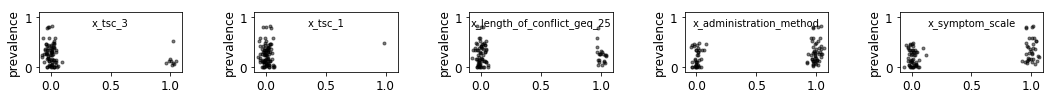

In [34]:
# set mpl defaults for nice display
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['lines.linewidth'] = 1
    
X = inp.filter(like='x_')
y = inp.value
for i, c_i in enumerate(X.columns):
    plt.subplot(4,5,1+i)
    plt.title('\n'+c_i, va='top', fontsize=10)
    plt.ylabel('prevalence')
    plt.plot(X[c_i]+np.random.normal(size=len(y))*.03, y, 'k.', alpha=.5)
    plt.axis(xmin=-.1, xmax=1.1, ymin=-.1, ymax=1.1)
    plt.subplots_adjust(hspace=.5, wspace=.5)

In [35]:
#dm.set_knots('p', [0, 2, 4, 6, 8, 10, 25, 55, 100])
#dm.set_knots('p', [0,3,10,20,30,45,55,70,85,100])
dm.set_knots('p', [0,2,4,6,8,10,15,20,25,30,45,85])
#dm.set_knots('p', [0, 10, 20, 30, 85])
dm.set_decreasing('p', 100, 100)
dm.parameters['ages'] = range(0,86)

In [36]:
dm.parameters['p']

{'decreasing': {'age_end': 100, 'age_start': 100},
 'fixed_effects': {},
 'heterogeneity': 'Very',
 'increasing': {'age_end': 0, 'age_start': 0},
 'level_bounds': {'lower': 0.0, 'upper': 1.0},
 'level_value': {'age_after': 100, 'age_before': 3, 'value': '0.0'},
 'parameter_age_mesh': [0, 2, 4, 6, 8, 10, 15, 20, 25, 30, 45, 85],
 'random_effects': {},
 'smoothness': {'age_end': 100, 'age_start': 0, 'amount': 'Slightly'},
 'y_maximum': 1.0}

In [37]:
dm.setup_model(rate_type='p', rate_model='neg_binom')

In [ ]:
def invalid_precision(dm):
    return dm.input_data.effective_sample_size.isnull() \
      & dm.input_data.standard_error.isnull() \
      & (dm.input_data.lower_ci.isnull() | dm.input_data.upper_ci.isnull())
dm.input_data[invalid_precision(dm)]

,data_type,value,area,sex,age_start,age_end,year_start,year_end,standard_error,effective_sample_size,lower_ci,upper_ci,age_weights,x_tsc_3,x_tsc_1,x_length_of_conflict_geq_25,x_administration_method,x_symptom_scale
13,p,0.066,Mexico,total,18,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,0


In [ ]:
%time dm.fit(how='mcmc', iter=1000000, burn=500000, thin=500)

finding initial values
.
.
.

finding MAP estimate

finding step covariances estimate

resetting initial values (1)
.
.
.

resetting initial values (2)

mare: 0.49
sampling from posterior



In [64]:
from matplotlib.pylab import *

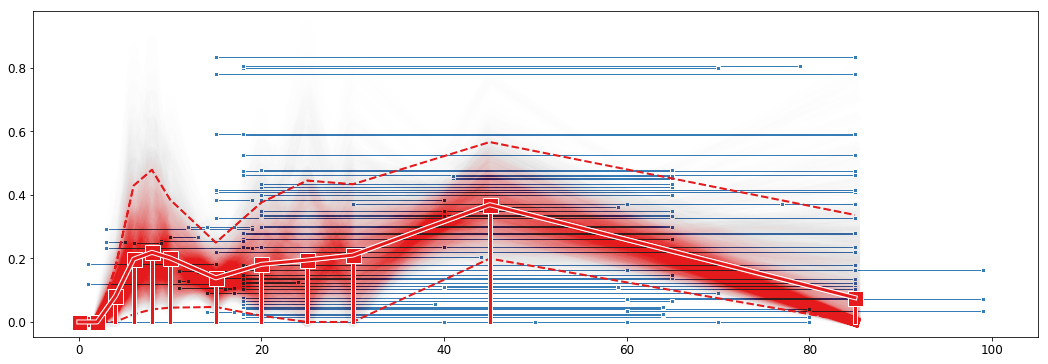

In [65]:
def plot(self, rate_type=None):
    import matplotlib.pyplot as plt, numpy as np
    import dismod_mr.plot as plot

    if rate_type or 'rate_type' in self.model_settings:
        plot_types = self.model_settings.get('rate_type', rate_type)
    else:
        plot_types = ['p', 'i', 'r', 'f']

    fig = plt.figure()

    for i, t in enumerate(plot_types):
        if len(plot_types) == 4:
            plt.subplot(2, 2, i+1)
            plt.title(t)
            plt.subplots_adjust(hspace=.5, wspace=.4)

        a0 = self.parameters['ages'][0]

        plot.data_bars(self.get_data(t), color=plot.colors[1])

        if t in self.vars:
            x = np.array(self.parameters['ages'])
            knots = self.vars[t].get('knots', np.array([]))

            if not hasattr(self.vars[t]['mu_age'], 'trace'):
                pt = self.vars[t]['mu_age'].value
                plt.plot(x, pt, linewidth=3, color=plot.colors[0])
                if len(knots) > 0:
                    plt.plot(knots, pt[knots-a0], 's', ms=15, mec='w', color=plot.colors[0])
            else:

                pred = self.vars[t]['mu_age'].trace()
                import pymc as mc
                ui =mc.utils.hpd(pred, .05)

                if len(knots) > 0:
                    plt.plot(x[knots-a0], ui[:, knots-a0].T, '--', linewidth=2, color=plot.colors[0], alpha=1)
                else:
                    plt.plot(x, ui, '--', linewidth=2, color=plot.colors[0], alpha=1)

                plt.plot(x, pred.T, linewidth=10, color=plot.colors[0], alpha=.005)
                plt.plot(self.parameters['ages'], pred.mean(0), linewidth=5, color='w')

                if len(knots) > 0:
                    xx = []
                    yy = []
                    for k_i in knots:
                        xx += [k_i, k_i, np.nan]
                        yy += [0., pred.mean(axis=0)[k_i-a0], np.nan]
                    plt.plot(xx, yy, linewidth=5, color='w')
                    plt.plot(xx, yy, linewidth=3, color=plot.colors[0])
                    plt.plot(self.parameters['ages'], pred.mean(0), linewidth=3, color=plot.colors[0])
                    plt.plot(knots, pred.mean(axis=0)[knots-a0], 's', ms=15, mec='w', color=plot.colors[0])

                import pymc as mc
                ui =mc.utils.hpd(pred, .05)
                plt.plot(x, pred.mean(0), linewidth=5, color='w')
                plt.plot(x, pred.mean(0), linewidth=3, color=plot.colors[0])

        plt.axis(xmin=-5, xmax=105)


plot(dm)
plt.savefig('anxiety_conflict_age.png')
#dismod_mr.plot.effects(dm, 'p', figsize=(18,12))
#plt.savefig('anxiety_conflict_effects.png')

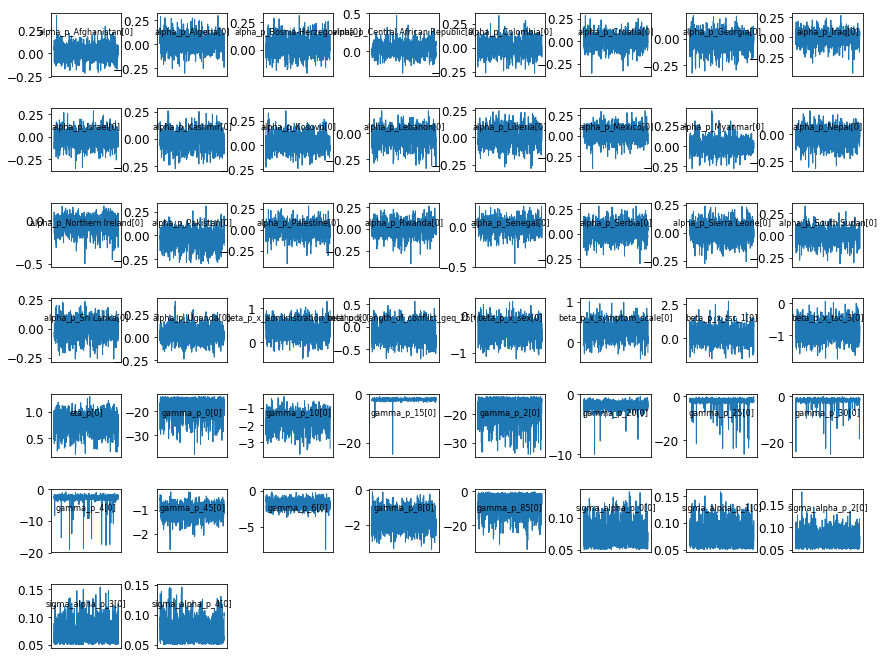

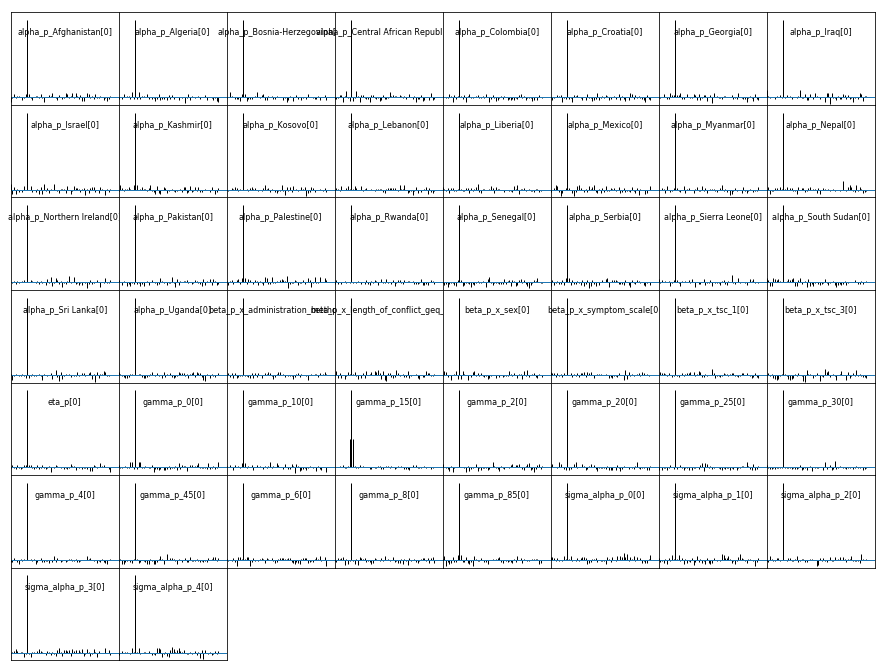

In [66]:
def plot_trace(model):
    def show_trace(trace):
        plt.plot(trace)
        plt.xticks([])

    plot_viz_of_stochs(model.vars, show_trace, (12,9))
    plt.subplots_adjust(.05,.01,.99,.99,.5,.5)

def plot_acorr(model):
    from matplotlib import mlab
    def acorr(trace):
        if len(trace) > 50:
            plt.acorr(trace, normed=True, detrend=mlab.detrend_mean, maxlags=50)
        plt.xticks([])
        plt.yticks([])
        l,r,b,t = plt.axis()
        plt.axis([-10, r, -.1, 1.1])

    plot_viz_of_stochs(model.vars, acorr, (12,9))
    plt.subplots_adjust(0,0,1,1,0,0)


def plot_viz_of_stochs(vars, viz_func, figsize=(8,6)):
    """ Plot autocorrelation for all stochs in a dict or dict of dicts

    :Parameters:
      - `vars` : dictionary
      - `viz_func` : visualazation function such as ``acorr``, ``show_trace``, or ``hist``
      - `figsize` : tuple, size of figure

    """
    plt.figure(figsize=figsize)

    cells, stochs = dismod_mr.plot.tally_stochs(vars)

    # for each stoch, make an autocorrelation plot for each dimension
    rows = np.floor(np.sqrt(cells))
    cols = np.ceil(cells/rows)

    tile = 1
    for s in sorted(stochs, key=lambda s: s.__name__):
        trace = s.trace()
        if len(trace.shape) == 1:
            trace = trace.reshape((len(trace), 1))
        for d in range(len(np.atleast_1d(s.value))):
            plt.subplot(rows, cols, tile)
            viz_func(np.atleast_2d(trace)[:, d])
            plt.title('\n\n%s[%d]'%(s.__name__, d), va='top', ha='center', fontsize=8)
            tile += 1

plot_trace(dm)
plot_acorr(dm)

[-5, 105, -0.39551730907736365, 0.65455913429507173]

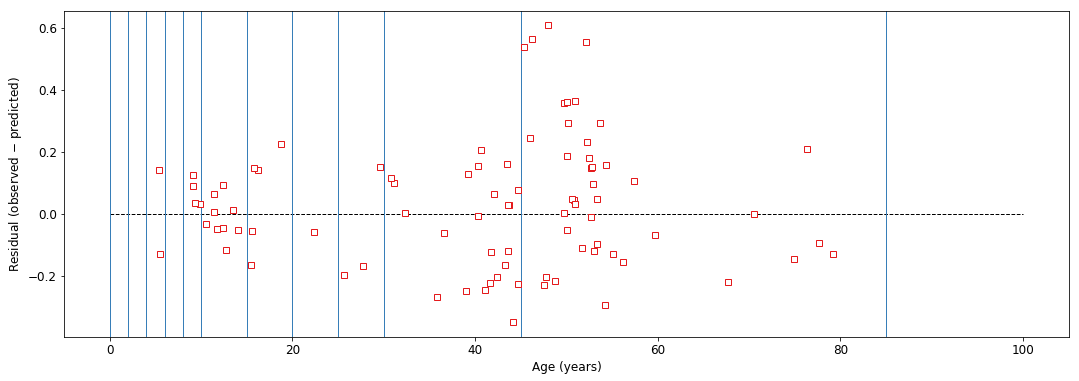

In [67]:
inp = dm.input_data
plt.plot((inp.age_start+inp.age_end)/2 + 2*np.random.randn(len(inp.index)),
     inp.value - dm.vars['p']['mu_interval'].trace().mean(axis=0), 's',
        mec=dismod_mr.plot.colors[0], mew=1, color='w')
hlines([0],0,100, linestyle='dashed')
xlabel('Age (years)')
ylabel('Residual (observed $-$ predicted)')
l,r,b,t = axis()
vlines(dm.parameters['p']['parameter_age_mesh'],-1,1, linestyle='solid', color=dismod_mr.plot.colors[1])
axis([-5,105,b,t])


In [68]:
countries = list(dm.input_data.area.unique())

dm.output_template = pd.DataFrame(dict(area=countries+countries,
                                       sex=['male']*len(countries) + ['female']*len(countries)))

for cov in dm.input_data.filter(like='x_'):
    dm.output_template[cov] = 0.

# FIXME: need to fill in correct UN_HDI value for given country/year
#dm.output_template['x_UN_HDI'] = df.UN_HDI.max()


dm.output_template['pop'] = 1  # pop is important for aggregating multiple areal units, but not relevant for this case
dm.output_template['year'] = 'all'

dm.output_template['x_sex'] = dm.output_template.sex.map({'male':.5, 'female':-.5})

In [69]:
def stats(self, alpha=0.05, start=0, batches=100,
          chain=None, quantiles=(2.5, 25, 50, 75, 97.5)):
    trace = self.trace()

    n = len(trace)
    if not n:
        print_(
            'Cannot generate statistics for zero-length trace in',
            self.__name__)
        return

    return {
        'n': n,
        'standard deviation': trace.std(0),
        'mean': trace.mean(0),
        '%s%s HPD interval' % (int(100 * (1 - alpha)), '%'): pm.utils.hpd(trace, alpha),
        #'mc error': batchsd(trace, min(n, batches)),
        #'quantiles': utils.quantiles(trace, qlist=quantiles)
    }


In [70]:
# Generate table of country and region effects, and sex effects:

t = pd.DataFrame([stats(s) for s in dm.vars['p']['alpha']])
t.index = [s.__name__ for s in dm.vars['p']['alpha']]
t.to_csv('anxiety_conflict_re.csv')
t

,95% HPD interval,mean,n,standard deviation
alpha_p_Pakistan,"[-0.221752361185, 0.126880005139]",-0.025340,1000,0.086513
alpha_p_Lebanon,"[-0.199774103649, 0.10518033637]",-0.036458,1000,0.080493
alpha_p_Israel,"[-0.198555599161, 0.136199832373]",-0.016117,1000,0.082638
alpha_p_Northern Ireland,"[-0.226164238332, 0.107071715951]",-0.048751,1000,0.086011
alpha_p_Georgia,"[-0.182091609654, 0.132939638879]",-0.023083,1000,0.078077
alpha_p_Mexico,"[-0.146974228856, 0.177388589949]",0.012437,1000,0.081683
alpha_p_Afghanistan,"[-0.136251280759, 0.159966778808]",0.014105,1000,0.076147
alpha_p_Nepal,"[-0.189282580236, 0.112621441658]",-0.022569,1000,0.077054
alpha_p_Iraq,"[-0.165301431971, 0.152733581007]",-0.012414,1000,0.079818
alpha_p_Kashmir,"[-0.174997730751, 0.137858141605]",-0.011740,1000,0.079038


In [71]:
t = pd.DataFrame([stats(s) for s in dm.vars['p']['beta']])
t.index = [s.__name__ for s in dm.vars['p']['beta']]
t.to_csv('anxiety_conflict_fe.csv')
t

,95% HPD interval,mean,n,standard deviation
beta_p_x_tsc_3,"[-1.4094408521, -0.304368229634]",-0.870263,1000,0.277426
beta_p_x_tsc_1,"[-0.859852101441, 1.34651491978]",0.173341,1000,0.575612
beta_p_x_length_of_conflict_geq_25,"[-0.543667746905, 0.252246672781]",-0.127522,1000,0.206924
beta_p_x_administration_method,"[-0.139175021162, 0.824791613876]",0.360316,1000,0.239664
beta_p_x_symptom_scale,"[-0.112573620922, 0.704498750713]",0.292249,1000,0.207037
beta_p_x_sex,"[-0.906930526075, 0.0942347579941]",-0.387242,1000,0.260225


In [72]:
s = stats(dm.vars['p']['mu_age'])

t = pd.DataFrame(dict(mean=s['mean'],
                      lb=s['95% HPD interval'].T[:,0],
                      ub=s['95% HPD interval'].T[:,1]),
                 index=dm.parameters['ages'],
                 columns=['mean', 'lb', 'ub'])

t.to_csv('anxiety_conflict_age.csv')
t.tail()

,mean,lb,ub
81,0.105839,1.868803e-02,0.331405
82,0.098519,1.402479e-02,0.334491
83,0.091199,9.361550e-03,0.338060
84,0.083879,4.698310e-03,0.339489
85,0.076559,1.554312e-15,0.337048


In [73]:
t.loc[[0,10,20,30,40,65,85]]

,mean,lb,ub
0,0.000000,0.000000e+00,0.000000
10,0.201623,4.513219e-02,0.385043
20,0.181637,1.953598e-02,0.376433
30,0.210465,9.986012e-12,0.433745
40,0.316395,1.920995e-01,0.427348
65,0.222959,1.288516e-01,0.348632
85,0.076559,1.554312e-15,0.337048


In [74]:
# Use mu_age as reference value prediction
pred_ref = dm.vars['p']['mu_age'].trace()

pred_ref.shape

(1000, 86)

In [75]:
dm.vars['p']['beta']

[<pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_tsc_3' at 0x7f18853e4518>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_tsc_1' at 0x7f188529c208>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_length_of_conflict_geq_25' at 0x7f188529c160>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_administration_method' at 0x7f18853f9048>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_symptom_scale' at 0x7f18853f94e0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'beta_p_x_sex' at 0x7f18853f9780>]

In [76]:
# extract prevalence predictions for specific age groups

dm.vars['p']['mu_interval'].trace().mean(axis=0)  # look at value 0, ess 0 rows of input data
# ages = [[0,5],
#         [5,15],
#         [15,30],
#         [30,45],
#         [45,60],
#         [60,70],
#         [70,80],
#         [80,85]]
# for age_start, age_end in ages:
#     inp = inp.append(pd.Series({'data_type':'p',
#                                 'value': 0,
#                                 'effective_sample_size':0,
#                                 'area': 'all',
#                                 'sex': 'total',
#                                 'age_start': age_start,
#                                 'age_end': age_end,
#                                 'x_tsc_3': False,
#                                 'x_tsc_1': False,
#                                 'x_length_of_conflict_geq_25': False,
#                                 'x_administration_method': False,
#                                 'x_symptom_scale': 0                                
#                                 }), ignore_index=True)

array([ 0.24304623,  0.16439945,  0.14752058,  0.26912859,  0.26912859,
        0.24304623,  0.26912859,  0.26912859,  0.16439945,  0.15604978,
        0.22360105,  0.23171438,  0.14752058,  0.26814627,  0.15578233,
        0.17657043,  0.25592766,  0.14525455,  0.32333163,  0.23171438,
        0.18469235,  0.23171438,  0.23171438,  0.15578233,  0.15139619,
        0.26142048,  0.23171438,  0.23171438,  0.16439945,  0.26814627,
        0.23171438,  0.15139619,  0.26738445,  0.26814627,  0.22847161,
        0.16555476,  0.11041528,  0.17001237,  0.23171438,  0.21274744,
        0.23171438,  0.23286356,  0.26346122,  0.17657043,  0.23171438,
        0.15604978,  0.17001237,  0.16439945,  0.31445949,  0.1516247 ,
        0.27218065,  0.22847161,  0.27218065,  0.23171438,  0.23286356,
        0.27218065,  0.30266125,  0.27218065,  0.16031439,  0.23286356,
        0.22847161,  0.23286356,  0.22847161,  0.27218065,  0.23171438,
        0.27218065,  0.27218065,  0.22847161,  0.30266125,  0.30

In [77]:
dm.vars['p'].keys()

dict_keys(['data', 'gamma', 'mu_age', 'ages', 'knots', 'smooth_gamma', 'unconstrained_mu_age', 'mu_sim', 'mu_age_derivative_potential', 'mu_interval', 'pi', 'U', 'U_shift', 'sigma_alpha', 'alpha', 'alpha_potentials', 'X', 'X_shift', 'beta', 'hierarchy', 'const_alpha_sigma', 'const_beta_sigma', 'eta', 'delta', 'p_obs', 'p_pred', 'covariate_constraint'])

In [78]:
dm.vars['p']['p_pred'].value.shape

(88,)

In [79]:
s = stats(dm.vars['p']['p_pred'])

tt = dm.vars['p']['data']
tt['mean'] = s['mean']*100
tt['lb'] = s['95% HPD interval'][0]*100
tt['ub'] = s['95% HPD interval'][1]*100

tt = tt.query('area == "all"').filter(['data_type', 'age_start', 'age_end', 'mean', 'lb', 'ub'])

np.round(tt, 1)

,data_type,age_start,age_end,mean,lb,ub
80,p,0,10,12.6,0.5,34.8
81,p,10,20,16.5,0.3,39.9
82,p,20,30,20.0,0.7,52.5
83,p,30,40,26.8,0.6,65.7
84,p,40,50,34.4,1.5,84.2
85,p,50,60,30.3,0.8,72.8
86,p,60,70,22.6,0.5,54.2
87,p,70,80,14.6,0.3,39.5


In [80]:
tt.to_csv('conflict_anxiety_by_age_group.csv')

In [81]:
population = pd.io.stata.read_stata('/home/j/Project/COD/envelope/data/age_weights_final.dta')
# add age start and age end columns to population DataFrame
population['age_start'] = population.age
population['age_end'] = list(population.age)[1:] + [101]

In [82]:
population.index = range(len(population.index))

In [83]:
age_index = dict([i, (population['age_end']<=i).sum()] for i in range(86))
age_group = dict([i, population.age_start[age_index[i]]] for i in range(86))

In [84]:
population.index = population.age_start

In [85]:
population.head()

,age,weight,age_start,age_end
age_start,,,,
0.00,0.00,0.000357,0.00,0.01
0.01,0.01,0.001062,0.01,0.10
0.10,0.10,0.016878,0.10,1.00
1.00,1.00,0.071823,1.00,5.00
5.00,5.00,0.086928,5.00,10.00


In [86]:
def prev_draws(df):
    age_specific_cases = df.filter(like='Draw').mul(df.Population, axis='index')
    age_specific_prev = age_specific_cases.sum() / df.Population.sum()
    
    return age_specific_prev

def age_std_prev(pred):
    df = pd.DataFrame(pred.T, index=range(86), columns=['Draw%03d'%i for i in range(1000)])
    df['age_group'] = df.index.map(lambda x: age_group[x])
    df['Population'] = 1.
    g = df.groupby('age_group')
    age_specific_prev_draws = g.apply(prev_draws)
    age_std_draws = age_specific_prev_draws.mul(population.weight, axis='index').sum()
    return age_std_draws.describe([.025, .975]).loc[['mean', '2.5%', '97.5%']].to_dict()

age_std_prev(pred_ref)

{'2.5%': 0.15528057066033135,
 '97.5%': 0.27952002361481609,
 'mean': 0.21108037845223296}

In [87]:
!date

Wed Oct  4 16:30:31 PDT 2017


In [88]:
s = stats(dm.vars['p']['p_pred'])

tt = dm.vars['p']['data']
tt['mean'] = s['mean']*100
tt['lb'] = s['95% HPD interval'][0]*100
tt['ub'] = s['95% HPD interval'][1]*100

tt = tt.query('area == "all"').filter(['data_type', 'age_start', 'age_end', 'mean', 'lb', 'ub'])

np.round(tt, 1)

,data_type,age_start,age_end,mean,lb,ub
80,p,0,10,12.6,0.5,34.8
81,p,10,20,16.5,0.3,39.9
82,p,20,30,20.0,0.7,52.5
83,p,30,40,26.8,0.6,65.7
84,p,40,50,34.4,1.5,84.2
85,p,50,60,30.3,0.8,72.8
86,p,60,70,22.6,0.5,54.2
87,p,70,80,14.6,0.3,39.5
